----------------------------------Run this part to create our dataset--------------------------------------------- 

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate


from sklearn.tree import DecisionTreeClassifier 

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import seaborn as sns



In [2]:
features_df = pd.read_csv('Data/training_set_features.csv', index_col="respondent_id")
labels_df = pd.read_csv('Data/training_set_labels.csv', index_col="respondent_id")
joined_df = features_df.join(labels_df, how = 'inner')

In [3]:
# an all-in-one data cleaning function. Do this BEFORE OHE
# Maybe this should be a class and worked into the pipeline?
def datacleaner(maindataframe):
    #For dropping whole columns 
    def columndrop(dataframe, column_list):
        dataframe.drop(column_list, axis = 1, inplace=True)
    #For dropping rows with na values
    def basicdropna(dataframe, column_list):
        dataframe.dropna(subset=column_list, inplace=True)
    #For special case imputation
    def impute_missing_data(dataframe, column_list, fillvalue):
        for column in column_list:
            dataframe[column].fillna(fillvalue, inplace = True)
    #This creates a number of lists of columns that fall into a few different 
    #categories, that will be processed in different ways. See notes below on how
    #these choices were made.
    drop_columns =  ['employment_industry',  'employment_occupation', 'hhs_geo_region']       
        
    general_dropna = ['health_worker', 'education','income_poverty', 'marital_status', 
                    'rent_or_own', 'employment_status', 'household_adults', 
                    'household_children' ]
        
    survey_col = ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
         'opinion_seas_vacc_effective', 'opinion_seas_risk','opinion_seas_sick_from_vacc']

    behavior_col = ['behavioral_antiviral_meds', 'behavioral_face_mask',
                'behavioral_large_gatherings','behavioral_outside_home']

    behavior_col_2 = ['behavioral_avoidance', 
                'behavioral_wash_hands','behavioral_touch_face']

    doc_rec = ['doctor_recc_h1n1','doctor_recc_seasonal']
    
    basicdropna(maindataframe, general_dropna)
    columndrop(maindataframe, drop_columns)
    impute_missing_data(maindataframe, survey_col, 3)
    impute_missing_data(maindataframe, ['h1n1_concern'], 2)
    impute_missing_data(maindataframe, ['h1n1_knowledge'], 0)
    impute_missing_data(maindataframe, behavior_col, 0)
    impute_missing_data(maindataframe, behavior_col_2, 1)
    impute_missing_data(maindataframe, doc_rec, 0)
    impute_missing_data(maindataframe, ['chronic_med_condition'], 0)
    impute_missing_data(maindataframe, ['child_under_6_months'], 0)


In [4]:
datacleaner(joined_df)

In [5]:
X=joined_df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
y=joined_df[['h1n1_vaccine','seasonal_vaccine']]

# Train test split, do this before OHE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# create OHE for objects, do this before imputer

cat_col_list = [i for i in X_train.select_dtypes(include='object').columns]

nb_list_for_ohe = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# Fits OHE on a subset of columns, then reintegrates them into the
# Origional dataframe. Do this after initial cleaning, before 
# health insurace imputation.

ohe = OneHotEncoder(drop='first', sparse=False)

def fit_trans_ohe(X_dataframe, columns):
    dums = ohe.fit_transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cols_dropped = X_dataframe.drop(columns, axis = 1)
    dums_df_concated = pd.concat([df_cols_dropped, dums_df], axis=1)
    return dums_df_concated

#We should end up with a fitted ohe instance called 'ohe'

In [7]:
X_train_ohe = fit_trans_ohe(X_train, cat_col_list+nb_list_for_ohe)

In [8]:
    
socio_economic_column_list = ["x0_35 - 44 Years","x0_45 - 54 Years","x0_55 - 64 Years","x0_65+ Years",
                              "x1_< 12 Years","x1_College Graduate","x1_Some College","x2_Hispanic",
                              "x2_Other or Multiple","x2_White","x3_Male", "x4_> $75,000", "x4_Below Poverty",
                              "x5_Not Married", "x6_Rent", "x7_Not in Labor Force","x7_Unemployed",
                              "x8_MSA, Principle City",'x8_Non-MSA', 'health_insurance']

# Fitting an imputer for Health Insurance using socio-economic features, 
# pulling from a dataframe that has already been OneHotEncoded


soc_eco_h_i_imputer_knn = KNNImputer()

def soc_eco_KNN_imputer(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.fit_transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round() 

    return output_df


In [9]:
X_train_imputed = soc_eco_KNN_imputer(soc_eco_h_i_imputer_knn, X_train_ohe, socio_economic_column_list)

In [10]:
# The OHE for the test set only, takes X test dataframe and list of columns to encoded:
def trans_ohe(X_dataframe, columns):
    dums = ohe.transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cols_dropped = X_dataframe.drop(columns, axis = 1)
    dums_df_concated = pd.concat([df_cols_dropped, dums_df], axis=1)
    return dums_df_concated

In [11]:
X_test_ohe = trans_ohe(X_test, cat_col_list+nb_list_for_ohe)

In [12]:
def imputer_transform_only(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round()
    
    return output_df

In [13]:
X_test_imputed = imputer_transform_only(soc_eco_h_i_imputer_knn, X_test_ohe, socio_economic_column_list)

### We now have a working dataset of: 
    'X_train_imputed' and 'y_train' to fit models to, 'X_test_ohe' to generate predictions, and 'y_test' to validate models with.

## 4. Final Model (Gradient Booster Classifier) 

- In section 3 Model Creation and Tuning, we explored four major machine learning classification algorithms: decision tree classifier, kNN, logistic regression, and the gradient boosting classifier.  AS the gradient boosting outperformed the other models and resulted in higher ROC, we chose the gradient boosting model as the best-fit model to predict both outcomes. 
- In this section, we check our model performance using test data. 
- For H1N1 model, the accuracy rate for the baseline model was 0.78. With our gradient boosting model applied, the accuracy rate increased to 0.84. 
- For seasonal flu model, the accuracy rate for the baseline model was 0.53. With our gradient boosting model applied, the accuracy rate jumped to 0.78. 
- Precision rate was 77% (seasonal) and 69%(H1N1). This is a fair number, as only 20 % of people are vaccinated for the H1N1 flu in our dataset.  
- Confusion matrix shows that, with our model, 10% of people are incorrectly labeled ‘vaccinated’ for seasonal flu, while 4% are labeled ‘vaccinated’ incorrectly for H1N1. False positive rates are not high. 
- ROC curves show a large improvement from the baseline model. 


#### Final Model (Gradient Booster)

In [14]:
# Model performance with test data 


# H1N1 

gbc_f_h1 = GradientBoostingClassifier(loss= 'exponential', learning_rate= .05, random_state = 14,
                                                max_depth=3, max_features='log2', n_estimators=700)

gbc_f_h1.fit(X_train_imputed, y_train['h1n1_vaccine'])

# Seasonal Flu

gbc_f_s = GradientBoostingClassifier(loss= 'exponential', learning_rate= .05, random_state = 14,
                                                max_depth=3, max_features='log2', n_estimators=700)

gbc_f_s.fit(X_train_imputed, y_train['seasonal_vaccine'])


GradientBoostingClassifier(learning_rate=0.05, loss='exponential',
                           max_features='log2', n_estimators=700,
                           random_state=14)

#### Accuracy Rate, Precision, Recall, F1-score

In [15]:
# Accuracy rate, Precision, Recall, F1-score
print('H1N1 Flu')
print(classification_report(y_test.h1n1_vaccine, gbc_f_h1.predict(X_test_imputed)) )
print()
print('Seasonal Flu')
print(classification_report(y_test.seasonal_vaccine, gbc_f_s.predict(X_test_imputed)) )

H1N1 Flu
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5119
           1       0.70      0.44      0.54      1440

    accuracy                           0.84      6559
   macro avg       0.78      0.69      0.72      6559
weighted avg       0.82      0.84      0.82      6559


Seasonal Flu
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      3486
           1       0.77      0.75      0.76      3073

    accuracy                           0.78      6559
   macro avg       0.78      0.77      0.78      6559
weighted avg       0.78      0.78      0.78      6559



#### Confusion Matrix

In [16]:
def confusion(model, dataframe, y):
    # get predicted y
    yhat = model.predict(dataframe)
    # confusion matrix
    cm = confusion_matrix(y, yhat)
    x_axis_labels = [ "No" , "Vaccinated"]
    y_axis_labels = [ "No" , "Vaccinated"]
    
    ax = sns.heatmap(cm/np.sum(cm), xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                       annot=True, 
            fmt='.2%', cmap='Blues')
    
    plt.xlabel('Prediction')
    plt.ylabel('Test Data')
    plt.show()
    
    # return heatmap
    return ax; 


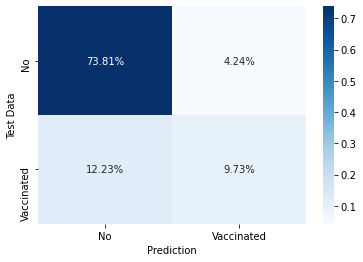

In [17]:
# Confusion Matrix for H1N1 
confusion(gbc_f_h1, X_test_imputed, y_test.h1n1_vaccine);


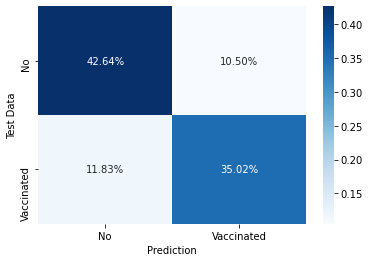

In [18]:
# Confusion Matrix for Seasonal Flu
confusion(gbc_f_s, X_test_imputed, y_test.seasonal_vaccine);

#### ROC-AUC

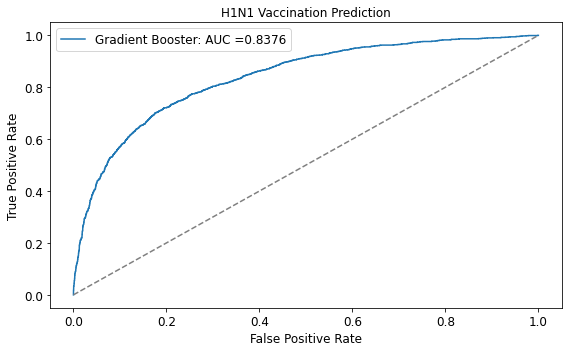

In [19]:

# Predicted Prob.
# H1N1
y_pred_h1_gbc = gbc_f_h1.predict_proba(X_test_imputed)[:, 1]

# Seasonal Flu
y_pred_s_gbc = gbc_f_s.predict_proba(X_test_imputed)[:, 1]


# FPR and TPR 
# H1N1
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test.h1n1_vaccine, y_pred_h1_gbc)
# Seasonal Flu
fpr_gbc_s, tpr_gbc_s, thresholds_gbc_s = roc_curve(y_test.seasonal_vaccine, y_pred_s_gbc)


# Plot the FPR and TPR data

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(fpr_gbc, tpr_gbc, alpha=1,
       label=f'Gradient Booster: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_gbc),4)}')

ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_title('H1N1 Vaccination Prediction', fontsize=12)
    
ax.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

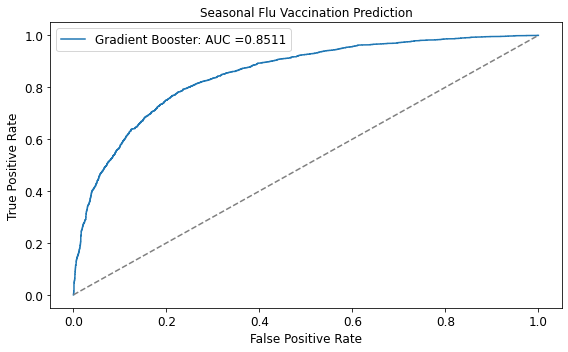

In [20]:
# Seasonal Flu 

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(fpr_gbc_s, tpr_gbc_s, alpha=1,
       label=f'Gradient Booster: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_gbc),4)}')

ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_title('Seasonal Flu Vaccination Prediction', fontsize=12)
    
ax.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

## 5. Feature Analysis 

#### Vaccination uptake across ethnicity 

In [21]:
# Create a new fate frame for feature analysis 

df = X_test.copy()

# Merge y_test 

df = pd.concat([df, y_test], axis=1) 

# Add predicted probabilities 

# H1N1 
df['h1n1_prob_0'] = gbc_f_h1.predict_proba(X_test_imputed)[:,0] 
df['h1n1_prob_1'] = gbc_f_h1.predict_proba(X_test_imputed)[:,1]

# Seasonal Flu
df['seasonal_prob_0'] = gbc_f_s.predict_proba(X_test_imputed)[:,0] 
df['seasonal_prob_1'] = gbc_f_s.predict_proba(X_test_imputed)[:,1]


In [22]:
df.groupby('race').h1n1_prob_1.mean()

race
Black                0.164134
Hispanic             0.203953
Other or Multiple    0.201696
White                0.215346
Name: h1n1_prob_1, dtype: float64

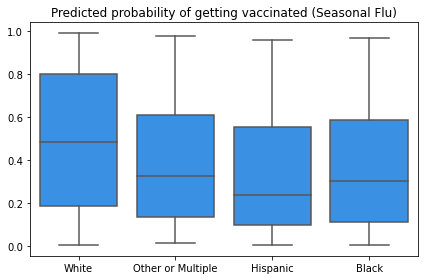

In [23]:
sns.boxplot(x="race", y="seasonal_prob_1",
                 data=df, color="dodgerblue")

#plt.title('Predicted probability of getting vaccinated (seasonal flu)')
plt.title('Predicted probability of getting vaccinated (Seasonal Flu)')
plt.ylabel('')
plt.xlabel('')
plt.grid(False)
plt.tight_layout();

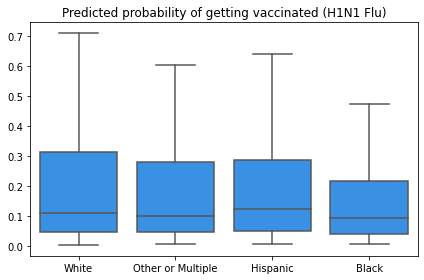

In [24]:

#df.boxplot(column='seasonal_prob_1', by ='race', showfliers = False)


sns.boxplot(x="race", y="h1n1_prob_1",
                 data=df, color="dodgerblue" , showfliers = False)

#plt.title('Predicted probability of getting vaccinated (seasonal flu)')
plt.title('Predicted probability of getting vaccinated (H1N1 Flu)')
plt.ylabel('')
plt.xlabel('')
plt.grid(False)
plt.tight_layout();

#### Important features within the model

In [25]:
zipzip = zip(gbc_f_s.feature_importances_,X_train_imputed.columns)
season_vax_fi = pd.DataFrame(data = zipzip, columns = ['importance','feature'])
zipzipzip = zip(gbc_f_h1.feature_importances_,X_train_imputed.columns)
h1n1_vax_fi = pd.DataFrame(data = zipzipzip, columns = ['importance','feature'])
h1n1_vax_fi.sort_values('importance', ascending = False, inplace = True)
h1n1_vax_fi_topten = h1n1_vax_fi.head(10)

h1n1_vax_fi_topten

,importance,feature
7,0.331434,doctor_recc_h1n1
25,0.105272,x12_4.0
22,0.097777,x11_5.0
26,0.073714,x12_5.0
11,0.052691,health_worker
37,0.029359,x15_4.0
8,0.025522,doctor_recc_seasonal
20,0.024069,x11_3.0
38,0.019857,x15_5.0
19,0.016928,x11_2.0


In [30]:
feat_renamed = ['Doc. Recomends H1N1 Vax', 'Moderate Concern: H1N1', 'Confident: H1N1 Vax Efficacy', 
                'Great Concern: H1N1', 'Health Care Worker', 'Moderate Concern: Flu', 'Doc. Recomends Flu Vax',
               'No Opinion: H1N1 Vax Efficacy', 'Great Concern: Flu', 'Moderate Concern: H1N1 Vax Efficacy']

h1n1_vax_fi_topten['Top Features'] = feat_renamed


<ipython-input-30-20bbc1c07475>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h1n1_vax_fi_topten['Top Features'] = feat_renamed


In [31]:
season_vax_fi.sort_values('importance', ascending = False, inplace = True)
season_vax_fi_topten = season_vax_fi.head(10)
season_vax_fi_topten

,importance,feature
8,0.153504,doctor_recc_seasonal
34,0.152898,x14_5.0
37,0.108192,x15_4.0
46,0.089857,x0_65+ Years
38,0.067101,x15_5.0
7,0.040195,doctor_recc_h1n1
31,0.039760,x14_2.0
11,0.030990,health_worker
25,0.025458,x12_4.0
62,0.020960,health_insurance


In [32]:
s_feat_renamed = ['Doc. Recomends Flu Vax', 'Great Confidence: Flu Vax Efficacy', 'Moderate Concern: Flu',
                  '65+ Years Old', 'Great Concern: Flu',  'Doc. Recomends H1N1 Vax', 
                  'Moderate Concern: Flu Vax Efficacy', 'Health Care Worker', 'Moderate Concern: H1N1',
                  'Has Health Insurance'
                  ]
season_vax_fi_topten['Top Features'] = s_feat_renamed

<ipython-input-32-3cc217aff177>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_vax_fi_topten['Top Features'] = s_feat_renamed


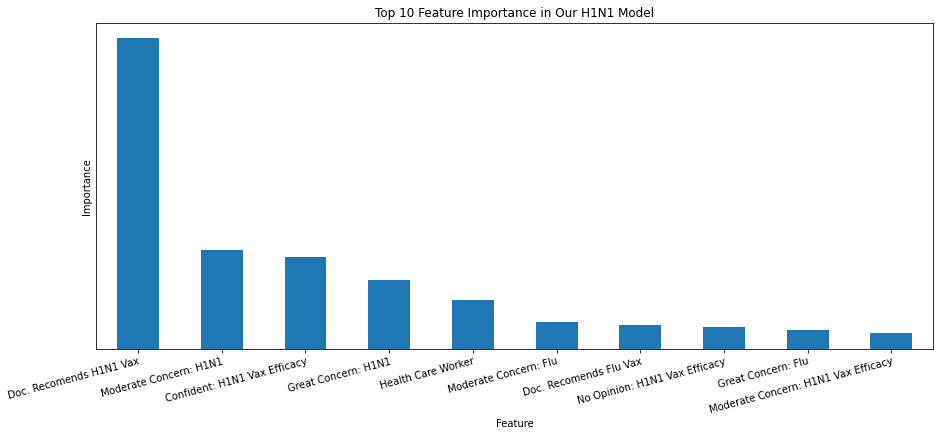

In [33]:
h1n1_vax_fi_topten.plot.bar(x= 'Top Features', y = 'importance', figsize = (15,6), title = 'Top 10 Feature Importance in Our H1N1 Model',
                    ylabel = 'Importance', xlabel = 'Feature', legend = None)
plt.xticks(rotation=15, rotation_mode='anchor', ha='right')
plt.yticks([]);

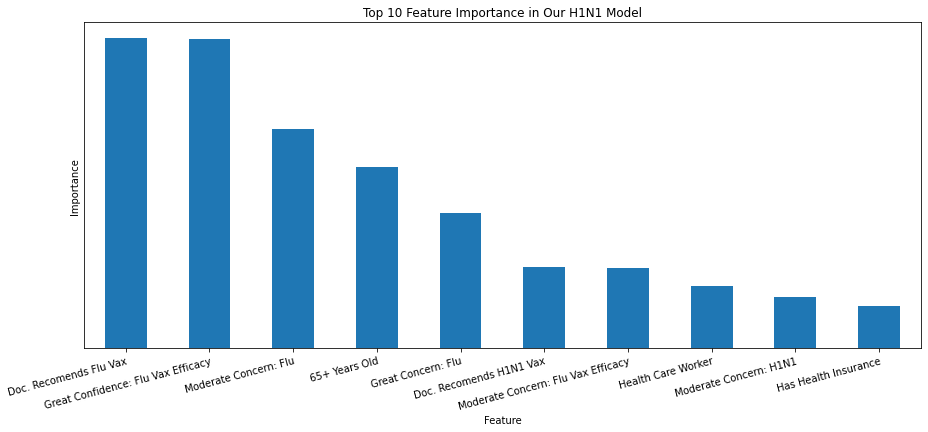

In [34]:
season_vax_fi_topten.plot.bar(x= 'Top Features', y = 'importance', figsize = (15,6), title = 'Top 10 Feature Importance in Our H1N1 Model',
                    ylabel = 'Importance', xlabel = 'Feature', legend = None)
plt.xticks(rotation=15, rotation_mode='anchor', ha='right')
plt.yticks([]);


In [35]:
joined_df.loc[joined_df['race'] == 'Black', ['seasonal_vaccine']].value_counts()

seasonal_vaccine
0                   1078
1                    573
dtype: int64

In [36]:
joined_df.loc[joined_df['race'] == 'White', ['seasonal_vaccine']].value_counts()

seasonal_vaccine
0                   8866
1                   8652
dtype: int64